In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
import pickle
from scipy.signal import convolve
import matplotlib.image as image
import sys
import matplotlib.colors as colors
import matplotlib.cm as cmx
import os
from scipy.fft import fft, fftfreq
from scipy.signal import  find_peaks
from scipy.optimize import curve_fit


# Impulse response of FB network and how it changes with w and tau (from Jenny's paper)

In [43]:
home = os.path.expanduser("~")

sys.path.insert(1, f'{home}/Documents/Repositories/motion_anticipation_network/model')
from utils import  DOG

In [72]:
#make impulse stimulus
def impulse_stimulus(length = 1.,impulse_timepoint = 0, amplitude = 1, dt = 0.001):


    tps = int(length/dt)
    barstim = np.zeros(tps)


    impulse_idx = int(impulse_timepoint/dt)
    barstim[impulse_idx] = amplitude

    #timeline = np.arange(0,length,self.dt)

    return barstim




def step_stimulus(length = 5.,start = 1.0, stop = 3.0, amplitude = 1, dt = 0.001):



    stimulus = (np.heaviside(np.arange(-start,length - start, dt), 1) - 1 * np.heaviside(
    np.arange(-stop, length - stop, step = dt),1)) * (amplitude)  


    #timeline = np.arange(0,length,self.dt)

    return stimulus




def main_frequency(signal, sampling_rate):
    """
    Calculate the main frequency of a signal.

    Parameters:
    signal (numpy array): The input signal (time domain).
    sampling_rate (float): The sampling rate of the signal in Hz.

    Returns:
    float: The main frequency of the signal in Hz.
    """
    # Number of samples in the signal
    N = len(signal)

    # Perform the Fast Fourier Transform (FFT)
    fft_values = fft(signal)

    # Get the corresponding frequencies
    frequencies = fftfreq(N, d=1/sampling_rate)

    # Only consider the positive frequencies (as FFT produces symmetric output)
    positive_frequencies = frequencies[:N // 2]
    positive_fft_values = np.abs(fft_values[:N // 2])

    # Find the frequency with the maximum amplitude in the FFT result
    main_freq_index = np.argmax(positive_fft_values)
    main_freq = positive_frequencies[main_freq_index]

    return main_freq



def calc_damping(tauA,tauB):
    return (1/tauA) + (1/tauB)


def expfun(t,tau,t0):
    return np.exp(-(tau)*(t-t0))* np.heaviside(t-t0,1)


def siggi(t,lam,phi,A,w):
    return A*np.exp(-lam*(t))* np.cos(w*(t)-phi)


# set network to work with

In [73]:
net = 'fb_linear'
# fp = f'{home}/Documents/Simulations/motion_anticipation_network/{net}'
fp = f'../../output/{net}'

# Figure Parameter

In [74]:
fontsize_legend = 20
fontsize_labels = 25
fontsize_panellabel = 30
fontsize_ticks = 20
lw = 4
ms = 60

figsize_ratio = 3

figsize = (8,8)
image_format = "png"
dpi = 300
panellabel_position = [-0.07, .85]


# Impulse response

# plot for multiple values of feedback weight wBA

-> with incresasing coupling strength impulse response changes from oni- to bi- to tri- and polyphasic

-> frequency increases with increasing weight 

-> step response changes from sustained to transient to osscillating

In [75]:
param = 'wBA'
wstring = r'$w^{B}_{A}$'
vals_w =np.array([0.,10.,20.,30.,40.]) #[46.0]        # values to test 


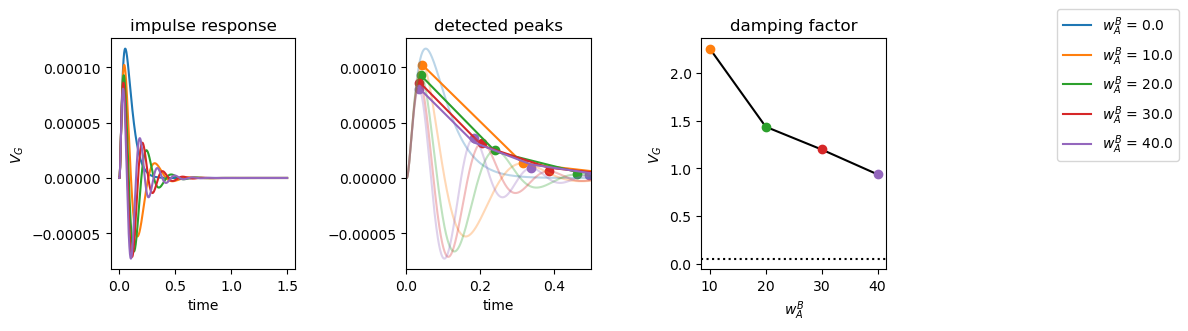

In [76]:
# detect damping

fig = plt.figure(figsize = (10,3))


gs = fig.add_gridspec(1,3)
ax0 = fig.add_subplot(gs[0,0])
ax00 = fig.add_subplot(gs[0,1])
ax1 = fig.add_subplot(gs[0,2])


fig.subplots_adjust(hspace = 0.6,
                    wspace = 0.6)


damp_w = []
freq_w = []
signal_w = []
peaks_x = []
peaks_y = []
popts = []
for i,val in enumerate(vals_w): 

    # load output 
    with open(f'{fp}/{param}/{val}/out_impulse', 'rb') as handle:
        out_impulse = pickle.load(handle)  

    with open(f'{fp}/params', 'rb') as handle:
        params = pickle.load(handle)    
    

    wAB = params['wAB']
    tauA = params['tauA']
    tauB = params['tauB']
    tauAB = 1/tauA + 1/tauB
    time_impulse = np.arange(0,len(out_impulse['VG']))*params['dt']  
    resp = out_impulse['VG']#/np.max(out_impulse['VG'])
    line = ax0.plot(time_impulse, resp, label = f'{wstring} = {np.round(val,2)}')
    ax00.plot(time_impulse, resp, color = line[0].get_color(), alpha = 0.3)

    peaks,heights = find_peaks(resp, height = 0)

    # damp_tau.append(calc_damping(tauA,tauB))
    if len(peaks) > 1:
        x = time_impulse[peaks]
        peaks_y.append(heights['peak_heights'])
        peaks_x.append(x)
    else:
        peaks_x.append(np.nan)
        peaks_y.append(np.nan)
        # x = out_impulse['VG'][out_impulse['VG'].argmax():]
        # peaks_x.append(out_impulse['VG'][out_impulse['VG'].argmax():])
        # peaks_y.append(time_impulse[out_impulse['VG'].argmax():])

    try:
        popt,_ = curve_fit(expfun,peaks_x[-1],peaks_y[-1],p0 = (5,0.03))
        frequency = main_frequency( out_impulse['VG'], 1/params['dt'])
        popts.append(popt[0]/frequency)

        ax00.plot(x,expfun(x,*popt),color = line[0].get_color())
        ax00.scatter(x,peaks_y[-1], color = line[0].get_color())
        ax1.scatter(val,popt[0]/frequency, zorder = 10,  color = line[0].get_color())


    except:
        popts.append(np.nan)
        frequency = np.nan

    frequency_tau = main_frequency( out_impulse['VG'], 1/params['dt'])
    signal_w.append(out_impulse['VG'])
    freq_w.append(frequency)



# ax1.plot(vals_w,np.array(damp_tau))
# ax1.plot(vals_tau,np.array(damp_tau)/2-3)
ax1.plot(vals_w[~np.isnan(popts)],np.array(popts)[~np.isnan(popts)], color = 'k')
ax1.axhline(1/tauAB, color = 'k', linestyle = ':')
ax0.set_xlabel('time')
ax0.set_ylabel('$V_{G}$')
ax0.set_title('impulse response')

ax00.set_xlabel('time')
ax00.set_title('detected peaks')
ax00.set_xlim(0,0.5)

ax1.set_xlabel(f'{wstring}')
ax1.set_ylabel('$V_{G}$')
ax1.set_title('damping factor')

fig.legend(loc = 'upper right', bbox_to_anchor = (1.2,1.))

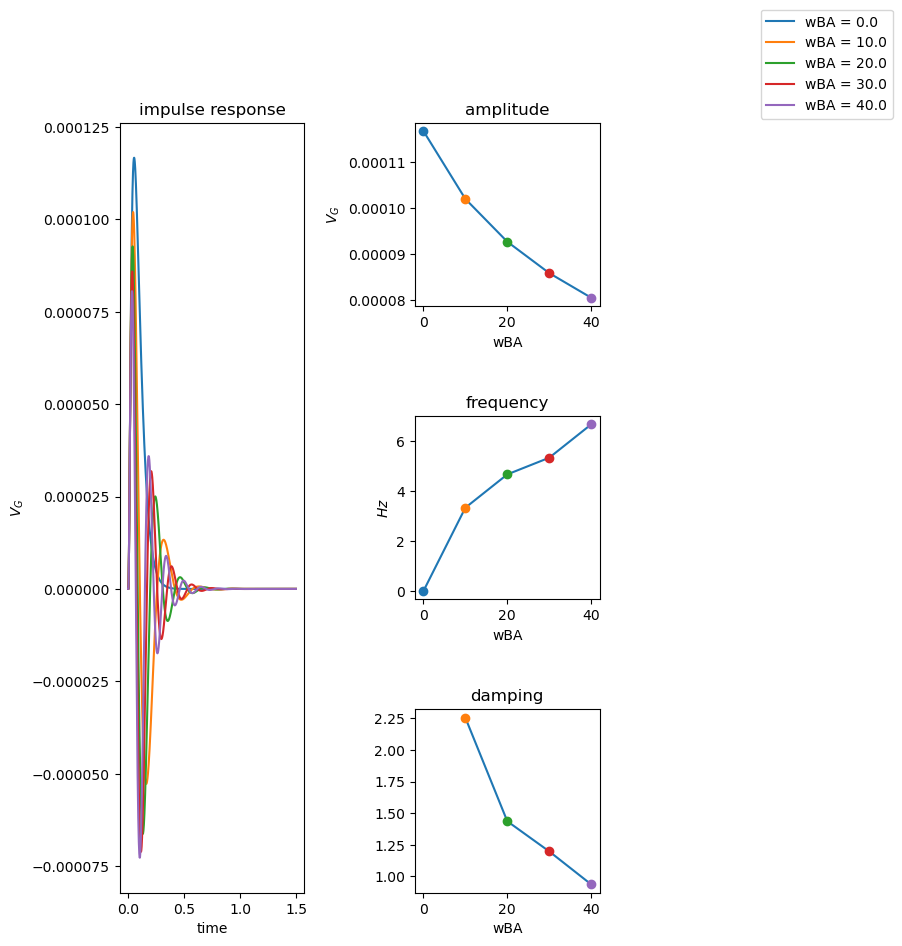

In [77]:
fig = plt.figure(figsize = (10,10))

gs = fig.add_gridspec(3,3)
ax0 = fig.add_subplot(gs[:,1])
ax1 = fig.add_subplot(gs[0,2])
ax2 = fig.add_subplot(gs[1,2])
ax3 = fig.add_subplot(gs[2,2], sharex = ax2)

fig.subplots_adjust(hspace = 0.6,
                    wspace = 0.6)


amp_w = []
freq_w = []
signal_w = []
for i,val in enumerate(vals_w): 

    # load output 
    with open(f'{fp}/{param}/{val}/out_impulse', 'rb') as handle:
        out_impulse = pickle.load(handle)  

    with open(f'{fp}/params', 'rb') as handle:
        params = pickle.load(handle)    
 
    time_impulse = np.arange(0,len(out_impulse['VG']))*params['dt']  

    ax0.plot(time_impulse, out_impulse['VG'], label = f'wBA = {val}')

    amp_w.append(np.max(out_impulse['VG']))

    frequency = main_frequency( out_impulse['VG'], 1/params['dt'])
    freq_w.append(frequency)
    signal_w.append(out_impulse['VG'])

    ax1.scatter(val,amp_w[-1], zorder = 10)
    ax2.scatter(val,freq_w[-1], zorder = 10)
    ax3.scatter(val,popts[i], zorder = 10)


ax1.plot(vals_w,amp_w)
ax2.plot(vals_w,freq_w)
ax3.plot(vals_w,popts)
  
ax0.set_xlabel('time')
ax0.set_ylabel('$V_{G}$')
ax0.set_title('impulse response')


ax1.set_xlabel('wBA')
ax1.set_ylabel('$V_{G}$')
ax1.set_title('amplitude')


ax2.set_xlabel('wBA')
ax2.set_ylabel('$Hz$')
ax2.set_title('frequency')


ax3.set_xlabel('wBA')
ax3.set_ylabel('')
ax3.set_title('damping')

fig.legend(loc = 'upper right', bbox_to_anchor = (1.2,1.))

# plot for multiple values of relative time constants (change distance between them same) 

-> only damping is affected
-> bigger tau damp more strongly 

In [78]:
param = 'tau'
vals = np.linspace(1.,10,10)



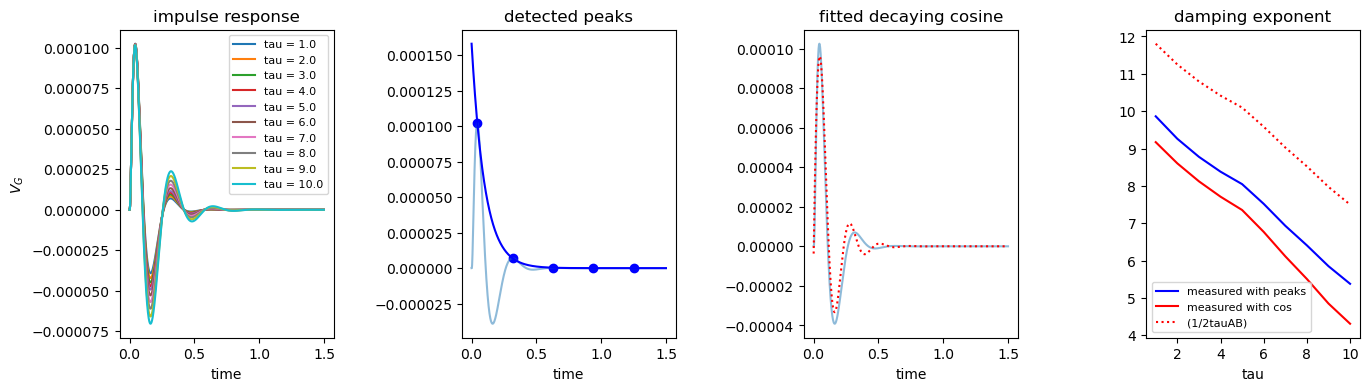

In [82]:
fig = plt.figure(figsize = (16,4))


gs = fig.add_gridspec(1,4)
ax0 = fig.add_subplot(gs[0,0])
ax00 = fig.add_subplot(gs[0,1])
ax01 = fig.add_subplot(gs[0,2])
ax1 = fig.add_subplot(gs[0,3])


fig.subplots_adjust(hspace = 0.6,
                    wspace = 0.6)


damp_w = []
freq_w = []
signal_w = []
peaks_x = []
peaks_y = []
popts = []
popts2 = []
tauAs = []
for i,val in enumerate(vals): 

    # load output 
    with open(f'{fp}/{param}/{val}/out_impulse', 'rb') as handle:
        out_impulse = pickle.load(handle)  

    with open(f'{fp}/params', 'rb') as handle:
        params = pickle.load(handle)    
    

    wAB = params['wAB']
    tauB = params['tauB']
    tauA =  np.round(1/(-val+1/tauB),2)
    tauAs.append(tauA)
    tauAB = 1/tauA + 1/tauB
    time_impulse = np.arange(0,len(out_impulse['VG']))*params['dt']  
    resp = out_impulse['VG']#/np.max(out_impulse['VG'])
    line = ax0.plot(time_impulse, resp, label = f'tau = {np.round(val,2)}')

    if i == 0:
        ax00.plot(time_impulse, resp, color = line[0].get_color(), alpha = 0.5)
        ax01.plot(time_impulse, resp, color = line[0].get_color(), alpha = 0.5)

    peaks,heights = find_peaks(resp, height = 0)

    # damp_tau.append(calc_damping(tauA,tauB))
    if len(peaks) > 1:
        x = time_impulse[peaks]
        peaks_y.append(heights['peak_heights'])
        peaks_x.append(x)
    else:
        peaks_x.append(np.nan)
        peaks_y.append(np.nan)
        # x = out_impulse['VG'][out_impulse['VG'].argmax():]
        # peaks_x.append(out_impulse['VG'][out_impulse['VG'].argmax():])
        # peaks_y.append(time_impulse[out_impulse['VG'].argmax():])

    try:
        popt,_ = curve_fit(expfun,peaks_x[-1],peaks_y[-1],p0 = (5,0.03))
        frequency = main_frequency(out_impulse['VG'], 1/params['dt'])
        dampapprox = 1/(2*(popt[0]/(frequency*2*np.pi)))
        damp = 1/(2*(popt[0]/np.sqrt(popt[0]**2 + (frequency*2*np.pi)**2)))
        damp = popt[0]
        popts.append(damp)
        if i == 0:
            ax00.plot(time_impulse,expfun(time_impulse,*popt), color = 'b')
            ax00.scatter(x,peaks_y[-1],color = 'b')
        # ax1.scatter(val,damp, zorder = 10,  color = line[0].get_color())
        # ax1.scatter(val,dampapprox,alpha = 0.1, s = 100, zorder = 10,  color = line[0].get_color())

    except:
        popts.append(np.nan)
        frequency = np.nan

    frequency = main_frequency(out_impulse['VG'], 1/params['dt'])
    winit = frequency*2*np.pi
    phinit = (1/time_impulse[np.argmax(out_impulse['VG'])])*2*np.pi
    laminit = 1/calc_damping(tauA,tauB)
    Ainit = np.max(out_impulse['VG'])
    popti,_ = curve_fit(siggi,time_impulse,out_impulse['VG'],p0 = (laminit,phinit,Ainit,winit),maxfev = 200000)
    if i ==0:
        ax01.plot(time_impulse,siggi(time_impulse,*popti), linestyle = ':', color = 'r')


    damp = popti[0]/popti[-1]
    damp = popti[0]
    # damp = popti[0]/popti[-1]
    popts2.append(damp)

    signal_w.append(out_impulse['VG'])
    freq_w.append(frequency)


# fig.legend(loc = 'upper right', bbox_to_anchor = (1.2,1.))
tauAs = np.array(tauAs)
# ax1.plot(vals_w,np.array(damp_tau))
# ax1.plot(vals_tau,np.array(damp_tau)/2-3)
ax1.plot(vals[~np.isnan(popts)],np.array(popts)[~np.isnan(popts)], color = 'b', label = 'measured with peaks')
ax1.plot(vals[~np.isnan(popts2)],np.array(popts2)[~np.isnan(popts2)], color = 'r', label = 'measured with cos')
# ax1.plot(vals, calc_damping(tauAs,tauB), color = 'k', linestyle = ':', label = '1/tauAB')
ax1.plot(vals, calc_damping(tauAs,tauB)*(1/2), color = 'r', linestyle = ':' , label = '(1/2tauAB)')
ax0.set_xlabel('time')
ax0.set_ylabel('$V_{G}$')
ax0.set_title('impulse response')
ax0.legend(fontsize = 8)

ax00.set_xlabel('time')
ax00.set_title('detected peaks')

ax01.set_xlabel('time')
ax01.set_title('fitted decaying cosine')
# ax00.set_xlim(0,0.7)


ax1.set_xlabel('tau')
ax1.set_title('damping exponent')
ax1.legend(fontsize = 8)
